In [1]:
#import basic library
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from time import time as t
from datetime import datetime as dt
from pickle import dump, load

#import tensorflow
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Input, LSTM, GRU, TimeDistributed, RepeatVector
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras import Sequential
from silence_tensorflow import silence_tensorflow

#import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve

#GPU test
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print(tf.__version__)
display(tf.test.is_built_with_cuda())
display(tf.test.is_built_with_gpu_support())

silence_tensorflow()

2022-07-26 18:38:19.865636: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


2.4.0


True

True

In [2]:
#autoencoder
def AutoEncoder(data_shape):
    model = Sequential()
    model.add(Input(shape=(data_shape[1], data_shape[2])))
    model.add(GRU(10, activation='relu', return_sequences=True))
    model.add(GRU(5, activation='relu', return_sequences=False))
    model.add(RepeatVector(data_shape[1]))
    model.add(GRU(5, activation='relu', return_sequences=True))
    model.add(GRU(10, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(data_shape[2])))
    return model

#preprocessing(setting data shape)
def preprocessing(data, scaler=None):
    data = np.array(data)
    drop_index = data.shape[0] % 20
    data = data[drop_index:,:]
    
    if scaler is None:
        scaler = StandardScaler()
        data = scaler.fit_transform(data)

    else:
        data = scaler.transform(data)

    data = data.reshape(-1, 20, 9)
    return data, scaler

class history_box:
    def __init__(self):
        self.history = {}

In [3]:
#data load
normal_path = './cap_data/ordinary'
abnormal_path = './cap_data/accident'
normal_csvs = os.listdir(normal_path)
abnormal_csvs = os.listdir(abnormal_path)

normal = [pd.read_csv(os.path.join(normal_path, i)) for i in normal_csvs]
abnormal = [pd.read_csv(os.path.join(abnormal_path, j)) for j in abnormal_csvs]

for i, df in enumerate(normal):
    df = df.dropna(axis=0)
    if i == 0:
        normal_data = df
    else:
        normal_data = pd.concat([normal_data, df])

for i, df in enumerate(abnormal):
    df = df.dropna(axis=0)
    if i == 0:
        abnormal_data = df
    else:
        abnormal_data = pd.concat([abnormal_data, df])

#data preprocessing
steady_data, scaler = preprocessing(normal_data)
accident_data, _ = preprocessing(abnormal_data, scaler=scaler)

#save scaler
with open('scaler.pkl', 'wb') as file:
    dump(scaler, file)

#split train, test dataset
X_train, X_valid = train_test_split(steady_data, random_state=26, test_size=0.2)

idx = np.random.choice(X_valid.shape[0], 65, replace=True)
idx2 = np.random.choice(accident_data.shape[0], accident_data.shape[0], replace=True)

X_test1 = X_valid[idx,:]
X_test2 = accident_data[idx2,:]
X_test = np.block([[[X_test1]], [[X_test2]]])

y_test1 = np.ones(X_test1.shape[0])
y_test2 = np.zeros(X_test2.shape[0])
y_test = np.block([y_test1, y_test2])

idx3 = np.arange(X_test.shape[0])
np.random.shuffle(idx3)

X_test = X_test[idx3]
y_test = y_test[idx3]

In [4]:
#define model 
model = AutoEncoder(X_train.shape)
print(X_train.shape)
model.compile(optimizer=Adam(learning_rate=0.01),
                  loss='mse', metrics=['mse'])
model.summary()

2022-07-26 18:38:21.477012: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-26 18:38:21.477697: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-07-26 18:38:21.519796: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA A100-SXM4-40GB MIG 7g.40gb computeCapability: 8.0
coreClock: 1.41GHz coreCount: 98 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2022-07-26 18:38:21.519815: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-07-26 18:38:21.521342: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-07-26 18:38:21.521375: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcubla

(25593, 20, 9)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 20, 10)            630       
_________________________________________________________________
gru_1 (GRU)                  (None, 5)                 255       
_________________________________________________________________
repeat_vector (RepeatVector) (None, 20, 5)             0         
_________________________________________________________________
gru_2 (GRU)                  (None, 20, 5)             180       
_________________________________________________________________
gru_3 (GRU)                  (None, 20, 10)            510       
_________________________________________________________________
time_distributed (TimeDistri (None, 20, 9)             99        
Total params: 1,674
Trainable params: 1,674
Non-trainable params: 0
_______________________________________

In [5]:
#model hyperprameters
epochs = 30
batch_size = 256
callbacks = [EarlyStopping(monitor='val_loss', patience=5)]
fitting = True

#model fitting
if fitting:
    history = model.fit(X_train, X_train, epochs=epochs, 
                        batch_size=batch_size, callbacks=callbacks,
                        validation_data=(X_valid, X_valid), verbose=True)
    #save model, history
    with open('history.pkl', 'wb') as file:
        dump(history.history, file)
    model.save("auto.h5")
    
else:
    #load model, history
    history = history_box()
    with open('history.pkl', 'rb') as file:
        history.history = load(file)
    model = load_model("auto.h5")

Epoch 1/30


2022-07-26 18:38:22.530841: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-07-26 18:38:22.552717: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2245770000 Hz
2022-07-26 18:38:25.193351: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11


  2/100 [..............................] - ETA: 8s - loss: 1.1717 - mse: 1.1717  

2022-07-26 18:38:25.732423: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-07-26 18:38:25.746440: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


100/100 [==============================] - 12s 93ms/step - loss: 0.8492 - mse: 0.8492 - val_loss: 0.5461 - val_mse: 0.5461
Epoch 2/30
100/100 [==============================] - 9s 87ms/step - loss: 0.5101 - mse: 0.5101 - val_loss: 0.4517 - val_mse: 0.4517
Epoch 3/30
100/100 [==============================] - 9s 87ms/step - loss: 0.4297 - mse: 0.4297 - val_loss: 0.4334 - val_mse: 0.4334
Epoch 4/30
100/100 [==============================] - 9s 91ms/step - loss: 0.4311 - mse: 0.4311 - val_loss: 0.4281 - val_mse: 0.4281
Epoch 5/30
100/100 [==============================] - 9s 92ms/step - loss: 0.4256 - mse: 0.4256 - val_loss: 0.4213 - val_mse: 0.4213
Epoch 6/30
100/100 [==============================] - 9s 92ms/step - loss: 0.4146 - mse: 0.4146 - val_loss: 0.4054 - val_mse: 0.4054
Epoch 7/30
100/100 [==============================] - 9s 92ms/step - loss: 0.3898 - mse: 0.3898 - val_loss: 0.3961 - val_mse: 0.3961
Epoch 8/30
100/100 [==============================] - 9s 89ms/step - loss: 0.38

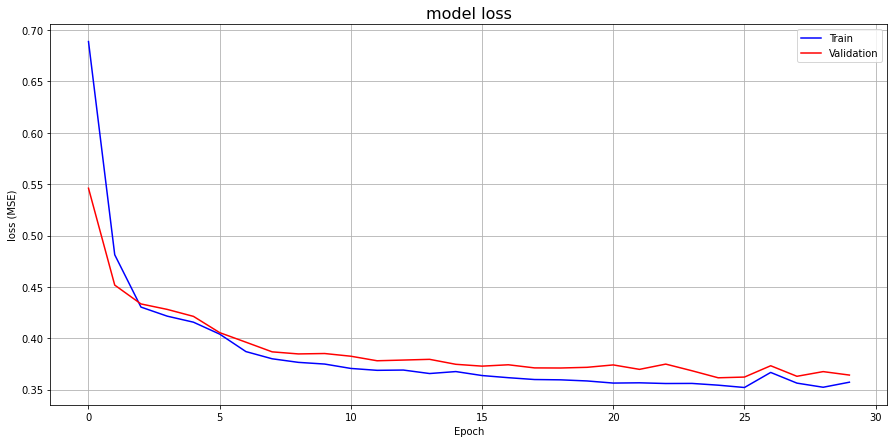

In [6]:
#Accuracy changes with epochs
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(history.history['loss'], 'b', label="Train")
ax.plot(history.history['val_loss'], 'r', label="Validation")
ax.set_title("model loss", fontsize=16)
ax.set_ylabel("loss (MSE)")
ax.set_xlabel("Epoch")
plt.grid()
plt.legend()
plt.show()

In [7]:
#test accident data
MSE = MeanSquaredError()

pre = model.predict(accident_data)
pre2 = model.predict(X_test)

print(MSE(pre, accident_data))
print(MSE(pre2, X_test))

tf.Tensor(7.116272449493408, shape=(), dtype=float64)
tf.Tensor(3.6662282943725586, shape=(), dtype=float64)


In [8]:
#fix threshold
mse = np.mean(np.mean(np.power(X_test - pre2, 2), axis=1), axis=1)
precision, recall, threshold = precision_recall_curve(y_test, mse)

ia = abs(precision - recall)
fix = threshold[np.argmin(ia)]
print(f"fix_mse : {fix}\norder : {np.argmin(ia)}")

fix_mse : 0.690099153962439
order : 64


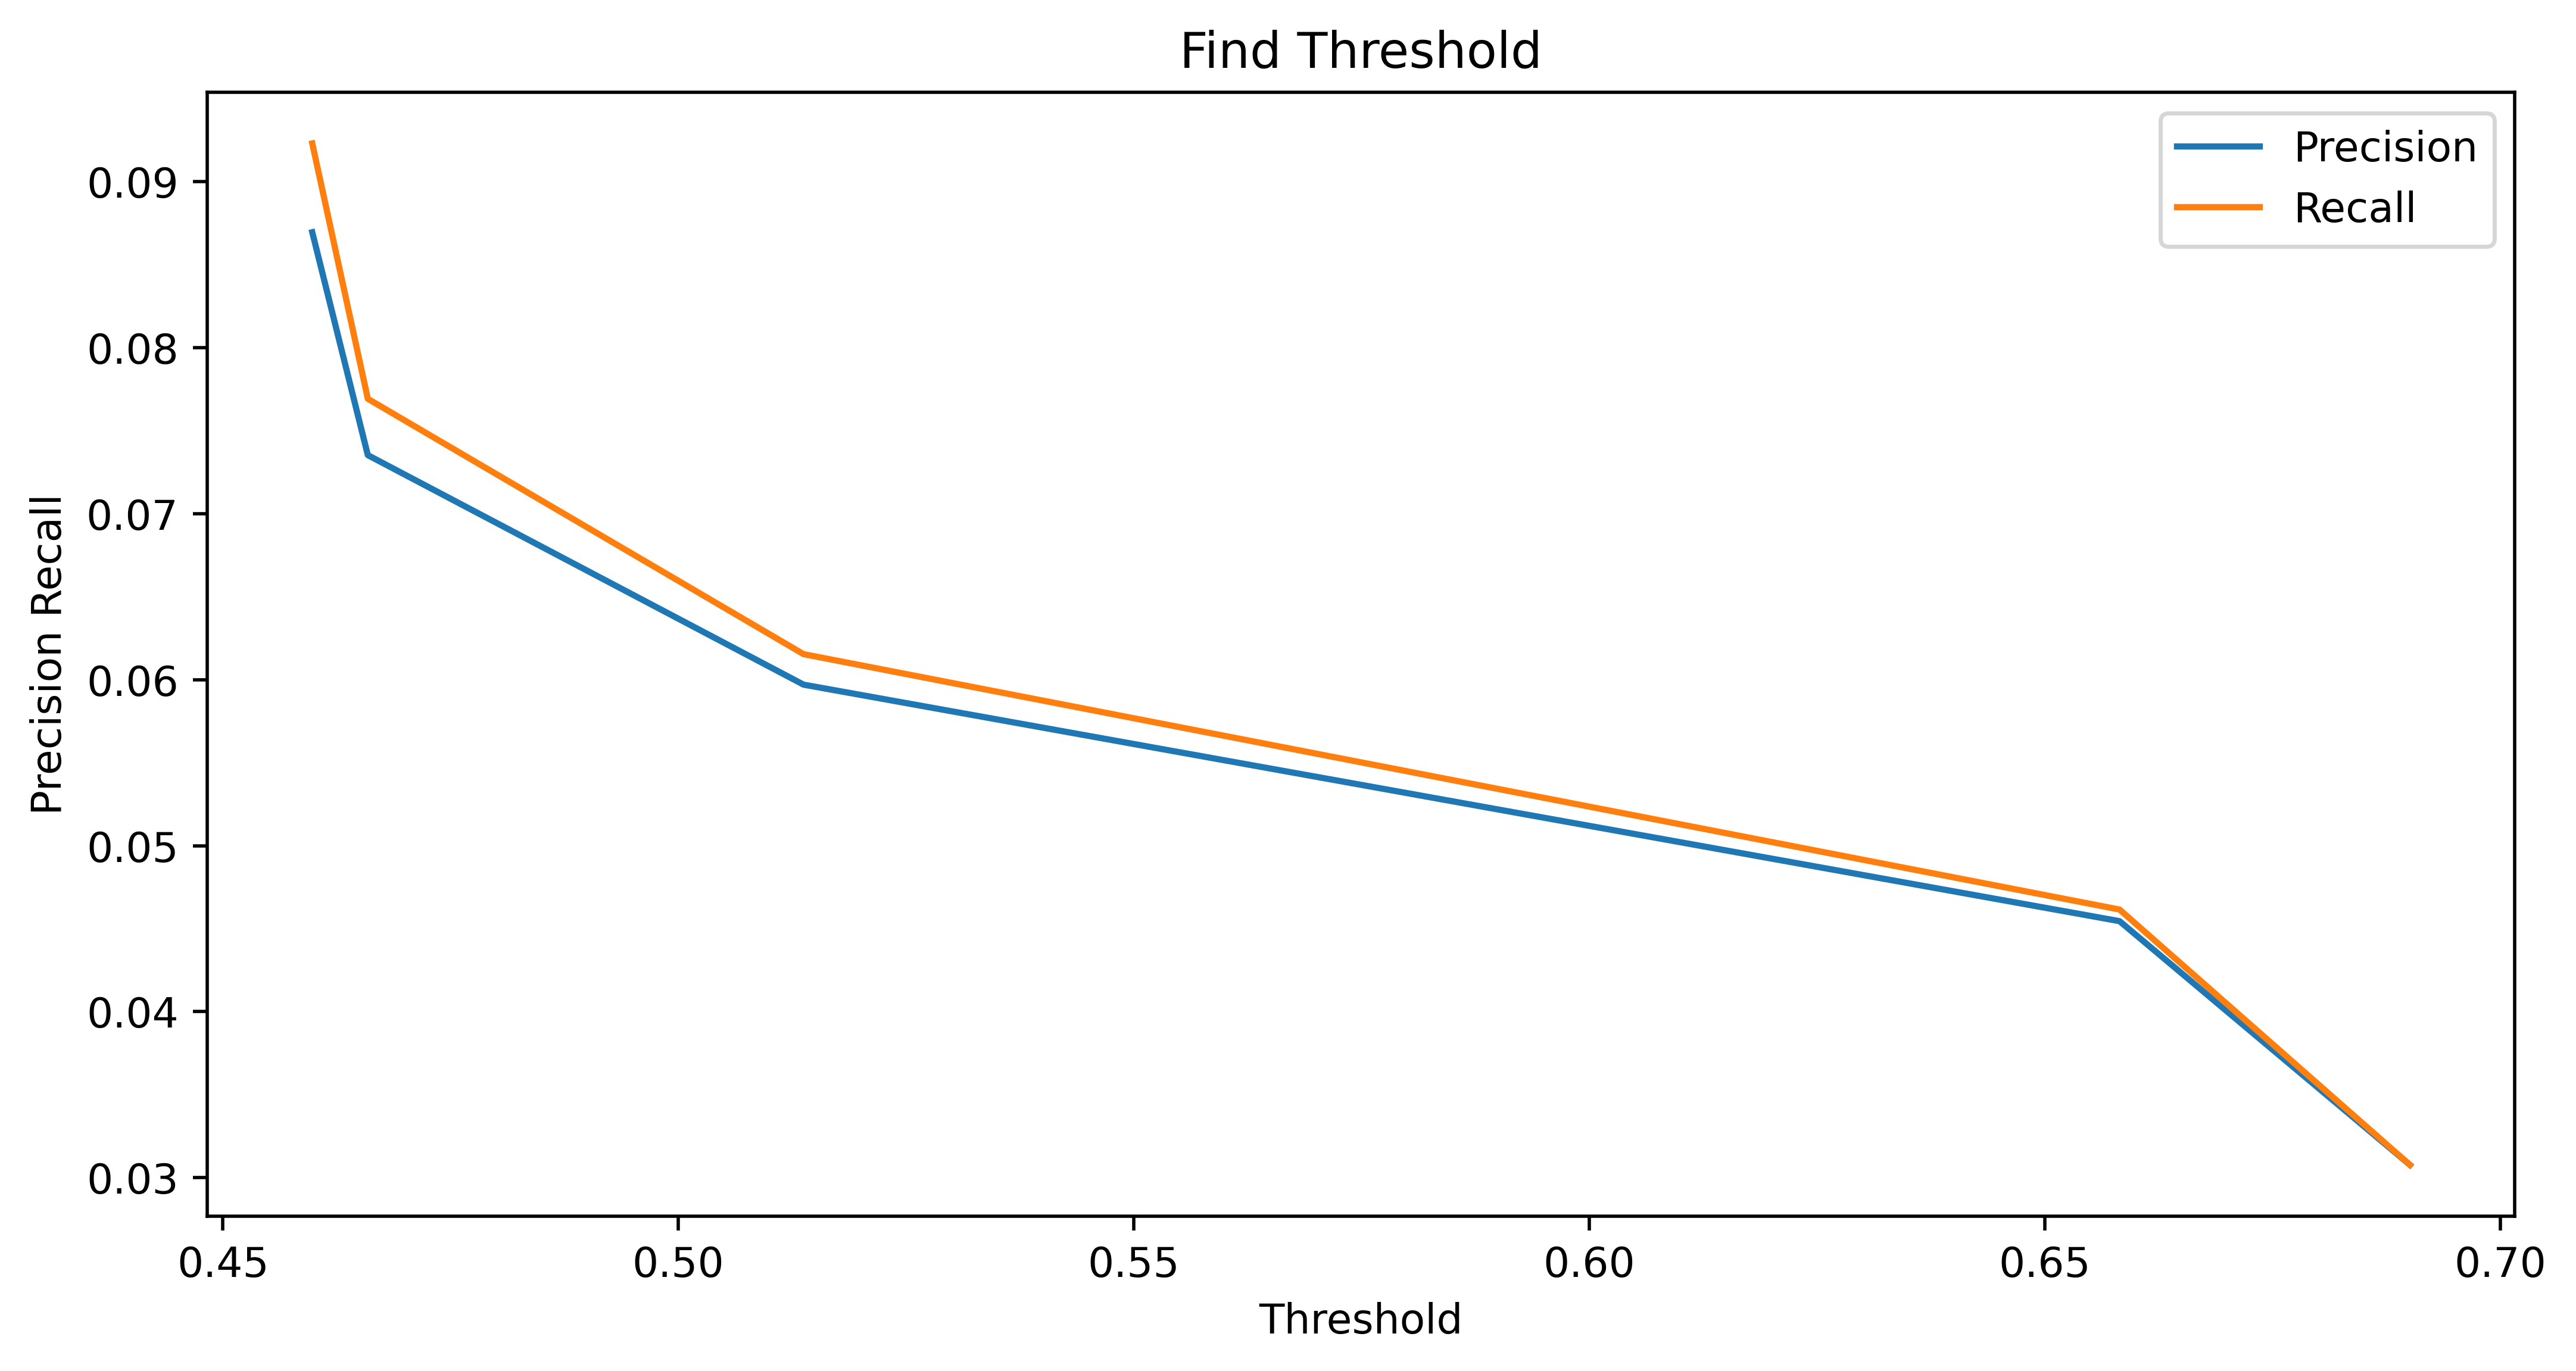

In [9]:
#plot recall, prediction and find threshold
plt.figure(figsize=(10, 5), dpi=500)
plt.plot(threshold[60:65], precision[60:65], label='Precision')
plt.plot(threshold[60:65], recall[60:65], label='Recall')
plt.title("Find Threshold")
plt.xlabel('Threshold')
plt.ylabel('Precision Recall')
plt.legend()
plt.show()

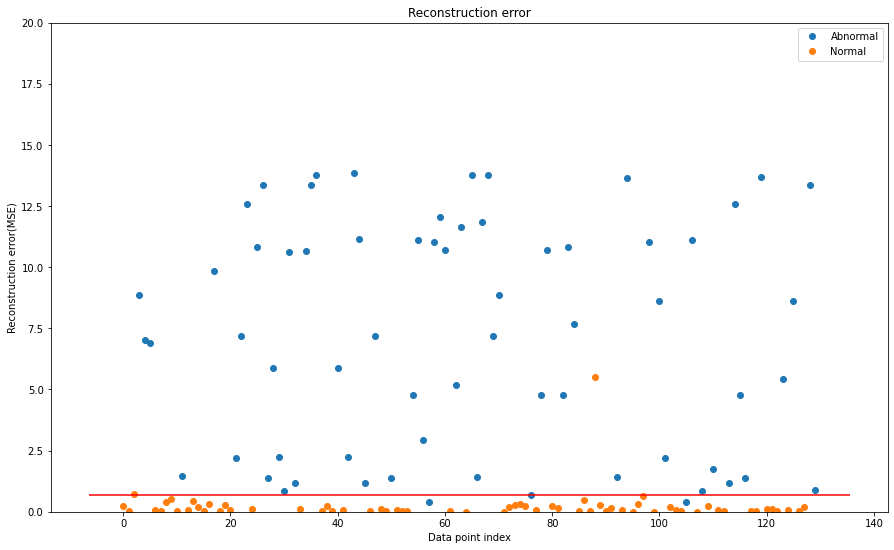

In [10]:
#visualization mse normal and abnormal data
error = pd.DataFrame({"error":mse, "True":y_test})
group = error.groupby("True")
fig, ax = plt.subplots(figsize=(15,9))
ax.plot()

for name, g in group:
    ax.plot(g.index, g.error, marker='o',label='Abnormal' if name == 0 else 'Normal', linestyle="")
    
ax.hlines(fix, ax.get_xlim()[0], ax.get_xlim()[1], color="r")
ax.legend(loc=1)
plt.title("Reconstruction error")
plt.ylabel("Reconstruction error(MSE)")
plt.xlabel("Data point index")
plt.ylim((0, 20))
plt.show()

In [11]:
#model quantized
or_model = load_model("./auto.h5")
converter = tf.lite.TFLiteConverter.from_keras_model(or_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

open("auto.tflite","wb").write(tflite_model)

2022-07-26 18:42:59.239296: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-07-26 18:43:02.005098: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2022-07-26 18:43:02.005271: I tensorflow/core/grappler/clusters/single_machine.cc:356] Starting new session
2022-07-26 18:43:02.005518: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-26 18:43:02.006331: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA A100-SXM4-40GB MIG 7g.40gb computeCapability: 8.0
coreClock: 1.41GHz coreCount: 98 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2022-07-26 18:43:02.006373: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.

45792

ptimize/quantize_weights.cc:222] Skipping quantization of tensor std.constant27 because it has fewer than 1024 elements (75).
2022-07-26 18:43:02.297557: I tensorflow/lite/tools/optimize/quantize_weights.cc:222] Skipping quantization of tensor std.constant36 because it has fewer than 1024 elements (300).
2022-07-26 18:43:02.297560: I tensorflow/lite/tools/optimize/quantize_weights.cc:222] Skipping quantization of tensor arg5 because it has fewer than 1024 elements (1).
2022-07-26 18:43:02.297564: I tensorflow/lite/tools/optimize/quantize_weights.cc:222] Skipping quantization of tensor std.constant37 because it has fewer than 1024 elements (150).
